In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.patches as patches
from collections import Counter
import os
import random
import xml.etree.ElementTree as ET
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import sys
import torch.optim as optim
from tqdm.notebook import tqdm
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [54]:
device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
labels_dict = {1: 'Eurasian_jay',
 2: 'great_spotted_woodpecker',
 3: 'greenfinch',
 4: 'blue_tit',
 5: 'Carduelis',
 6: 'common_redpoll',
 7: 'great_tit',
 8: 'bullfinch',
 9: 'Eurasian_siskin',
 10: 'Eurasian_tree_sparrow',
 11: 'hawfinch',
 12: 'willow_tit',
 13: 'Fieldfare',
 14: 'Common_chaffinch',
 15: 'Common_linnet'}
n_classes = len(labels_dict)  # number of classes
color_dict = {i:color/255 for i,color in enumerate(np.random.uniform(0, 255, size=(n_classes, 3)))}

In [40]:
def xml_transform(xml_path):
    xml = ET.parse(xml_path)
    root = xml.getroot()
    img_name = root[1].text
    labels, boxes = [], [] 
    
    for obj in root.iter('object'):
        label = obj[0].text
        if label == 'Common chaffinch':
            label = 'Common_chaffinch'
        try:
            label = [label == species for species in labels_dict.values()].index(True) + 1
        except ValueError:
            print(xml_path)
                
        labels.append(label)
        box = [int(coord.text) for coord in obj[4]]
        boxes.append(box)
    target = {'boxes' : torch.as_tensor(boxes, dtype=torch.float32),
              'labels' : labels}
    return img_name, target

def count_classes(path_annotations):
    target_list = []
    xml_list = [os.path.join(path_annotations, file) for file in os.listdir(path_annotations)]
    for xml in xml_list:
        _, target = xml_transform(xml)
        target_list += target['labels']
    return Counter(target_list) 
    

In [41]:
path_annotations = "/content/drive/MyDrive/birds/birds/annotations/" 
images_dir = "/content/drive/MyDrive/birds/birds/"

path_annotations = "/home/costia/birds/annotations/" #"/home/costia/birds_project/detect/annotations/check/"
images_dir = "/home/costia/birds/"

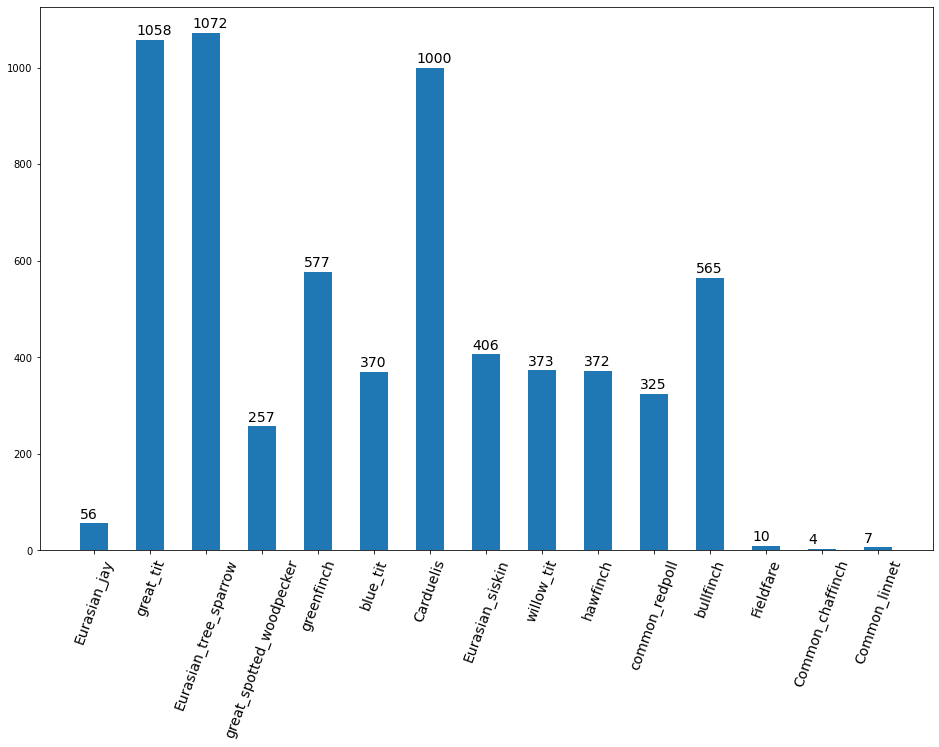

In [158]:
#class distribution
labels, values = zip(*count_classes(path_annotations).items())
indexes = np.arange(len(labels))
#add name of species
labels = [labels_dict[lab] for lab in labels if lab != 0]
width = 0.5
plt.figure(figsize = (16,10))
plt.bar(indexes, values, width, align='edge')
plt.xticks(indexes + width * 0.5, labels, rotation=70, fontsize=14)
for ind,val in zip(indexes, values):
    plt.text(x=ind, y =val+10, s=str(val), fontdict=dict(fontsize=14), color = 'black')
plt.show()

In [44]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [45]:
def train_val_split(path_annotations, val_size=.25, seed=773):
    random.seed(seed)
    path_list = [os.path.join(path_annotations, path) for path in os.listdir(path_annotations)]
    val_size = int(len(path_list)*val_size)
    val_paths = random.sample(path_list, val_size)
    train_paths = list(set(path_list) - set(val_paths)) 
    return train_paths, val_paths
    

In [46]:
def plot_detection(img, info, with_text=False, conf_lvl=0.3, swap=True,
                   color_dict=color_dict):
    fig, ax = plt.subplots()
    img = img.permute((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img.numpy() + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    img = np.clip(img, 0, 1)
    
    if swap:
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
        img = np.clip(img, 0, 1)
    ax.imshow(img)
    flag = False
    if 'scores' in info.keys():
        mask = info['scores'] >= conf_lvl
        confidences = info['scores'][mask]
        boxes = info['boxes'][mask]
        labels = info['labels'][mask]
        
        flag = True
    else:
        
        boxes = info['boxes']
        labels = info['labels']
    
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        height = y_max - y_min
        width = x_max - x_min
        
        label = labels_dict [int(labels[i])]
        color = color_dict[int(labels[i])]
        rect = patches.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor=color,
                                 facecolor='none')
        ax.add_patch(rect)
        if with_text:
            if flag:
                text = '{} {:.0f}%'.format(label, confidences[i]*100)
            else:
                text = '{}'.format(label)
            ax.text(x_min, y_min, text,
                    bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [47]:
def compute_iou(groundtruth_box, detection_box):
    g_ymin, g_xmin, g_ymax, g_xmax = groundtruth_box.tolist()
    d_ymin, d_xmin, d_ymax, d_xmax = detection_box.tolist()
    
    #find maximum of minimal coordinates and minimum of maximal coordinates
    
    xa = max(g_xmin, d_xmin)
    ya = max(g_ymin, d_ymin)
    xb = min(g_xmax, d_xmax)
    yb = min(g_ymax, d_ymax)
    
    #area of intersection
    intersection = max(0, xb - xa + 1) * max(0, yb - ya + 1)

    truth_area = (g_xmax - g_xmin + 1) * (g_ymax - g_ymin + 1)
    detected_area = (d_xmax - d_xmin + 1) * (d_ymax - d_ymin + 1)

    return intersection / float(truth_area + detected_area - intersection)

In [48]:
def confusion_matrix(batch_gen, model, treshold = 0.7, iou_treshold = 0.6):
    '''
    Greate confusion matrix based on models predictions on 
    given data generator with pdedicted labels.
    plot matrics with percentage of each type of predicted classes.
    input: batch genarator, model, class treshold, iou treshold
    output: plots confusion matrix
    '''
    conf_matr = np.zeros((num_classes-1,num_classes-1))
    
    model.eval()
    for imgs,targets_b in tqdm(batch_gen):
        inputs = list(img.to(device) for img in imgs)
        targets_batch = [{k:v.to(device) for k,v in t.items()} for t in targets_b] 
        predictions = model(inputs)
        for preds, targets in zip(predictions,targets_batch):
            vals = preds['scores'] > treshold

            pred_boxes = preds['boxes'][vals]
            pred_labels = preds['labels'][vals]

            for j, box in enumerate(pred_boxes):
                for i, gt_box in enumerate(targets['boxes']):
                    iou = compute_iou(groundtruth_box=gt_box,detection_box=box)
                    if iou > iou_treshold:
                        real_label = int(targets['labels'][i])
                        pred_label = int(pred_labels[j])
                        conf_matr[real_label-1,pred_label-1] += 1
    
    names = [labels_dict[n] for n in labels_dict]
    
    cm_sum = np.sum(conf_matr, axis=1, keepdims=True)
    cm_perc = conf_matr / cm_sum.astype(float) * 100
    annot = np.empty_like(conf_matr).astype(str)
    nrows, ncols = conf_matr.shape
    for i in range(nrows):
        for j in range(ncols):
            c = conf_matr[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    df_cm = pd.DataFrame(conf_matr, index = names,
                      columns = names)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (16,10))
    sns.heatmap(df_cm, annot=annot, fmt='', linewidths=1)
            
    

In [49]:
train_transform = transforms.Compose([
                            transforms.ToTensor(),
                            
                            #transforms.Grayscale(),
                            transforms.ColorJitter(brightness=.5, hue=.3),
                            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                            transforms.RandomInvert(),
                            #transforms.RandomPosterize(bits=2),
                            transforms.RandomSolarize(threshold=192.0),
                            transforms.RandomAdjustSharpness(sharpness_factor=2),
                            transforms.RandomAutocontrast(),
                            #transforms.RandomEqualize(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                            

                        ])

val_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

In [50]:
class BirdsDataset(torch.utils.data.Dataset):
    def __init__(self, transform, annotation_paths, images_dir):
        self.transform = transform
        self.annotation_paths = annotation_paths
        self.images_dir = images_dir
        
    def __len__(self):
        return len(self.annotation_paths)
    
    def __getitem__(self,idx):
        path = self.annotation_paths[idx]
        img_name, target = xml_transform(path)
        #target['labels'] = [list(labels_dict.keys())[list(labels_dict.values()).index(label)] for label in target['labels']]
        target['labels']  = torch.as_tensor(target['labels'], dtype=torch.int64) 
        img_path = os.path.join(self.images_dir,img_name)
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        
        return img, target
        
        
        

In [51]:
batch_size = 2
val_size = 0.25
train_ann_path, val_ann_path = train_val_split(path_annotations, val_size=val_size, seed=779)

train_dataset = BirdsDataset(transform=train_transform,
                            annotation_paths = train_ann_path,
                            images_dir  = images_dir)

val_dataset = BirdsDataset(transform=val_transform,
                            annotation_paths = val_ann_path,
                            images_dir  = images_dir)

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, 
                                              shuffle = True,
                                            collate_fn=collate_fn)

val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size,
                                            shuffle = True,
                                            collate_fn=collate_fn)

dataloaders = {'train': train_batch_gen,
               'val': val_batch_gen}

dataset_sizes = {'train' : len(train_dataset),
                 'val' : len(val_dataset)}

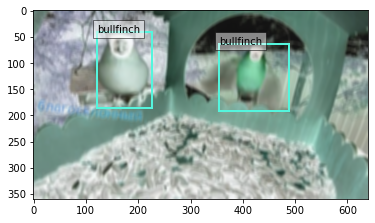

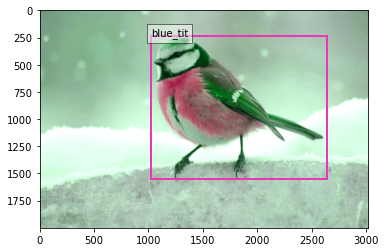

In [52]:
imgs, boxes= next(iter(train_batch_gen))
for img, info in zip(imgs, boxes):
    plot_detection(img, info, with_text=True, swap = False,
                   color_dict=color_dict)


## Model and training


In [176]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#load Faster R-CNN pre-trained on COCO dataset
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)#fasterrcnn_resnet50_fpn(pretrained=True)
#Change the classifier head with a new one:
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = n_classes+1 #(n_classes + background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)
print("Model loaded successfully")

Model loaded successfully


Starting epoch 0


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.
Saving weights...
Starting epoch 1


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.
Saving weights...


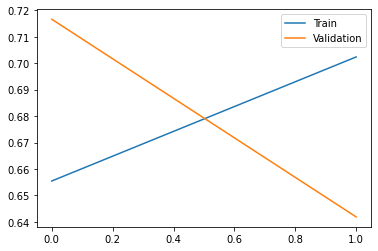

Starting epoch 2


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


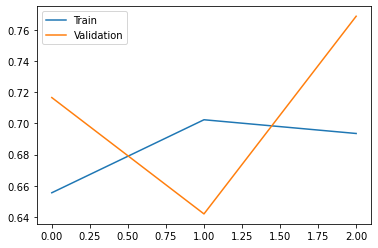

Starting epoch 3


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


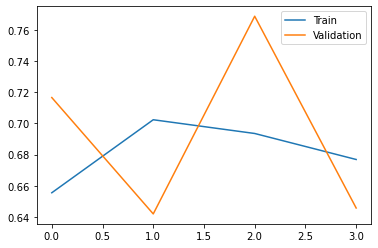

Starting epoch 4


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.
Saving weights...


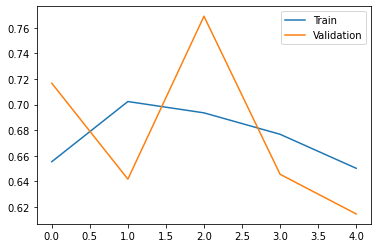

Starting epoch 5


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


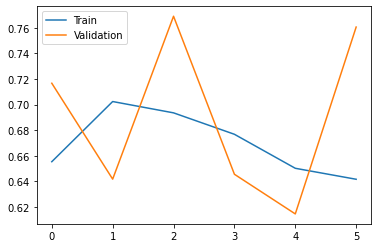

Starting epoch 6


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


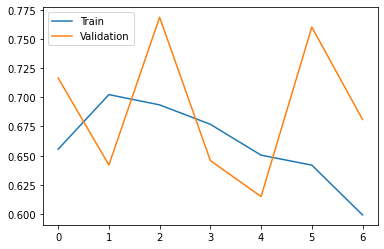

Starting epoch 7


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.
Saving weights...


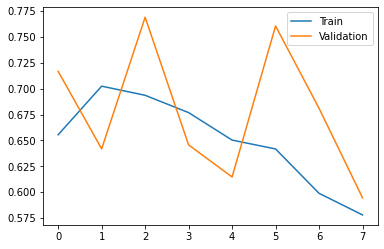

Starting epoch 8


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.
Saving weights...


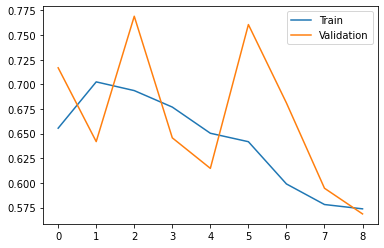

Starting epoch 9


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


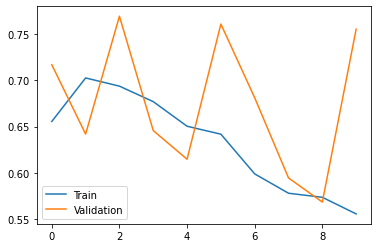

Starting epoch 10


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


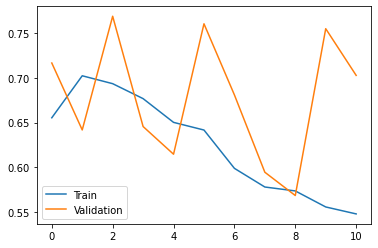

Starting epoch 11


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


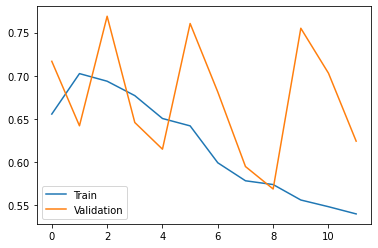

Starting epoch 12


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


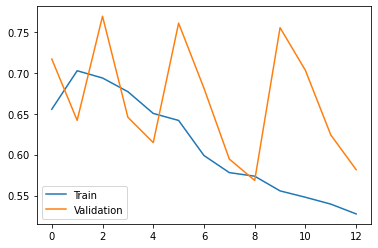

Starting epoch 13


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


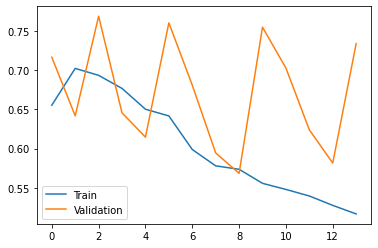

Starting epoch 14


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


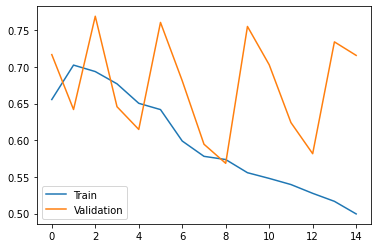

Starting epoch 15


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


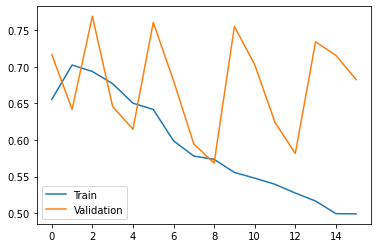

Starting epoch 16


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


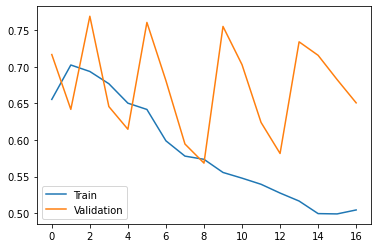

Starting epoch 17


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


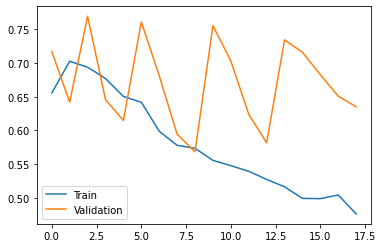

Starting epoch 18


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


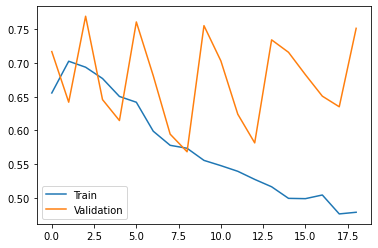

Starting epoch 19


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


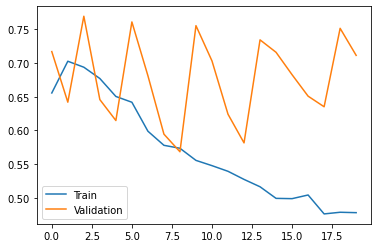

Starting epoch 20


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


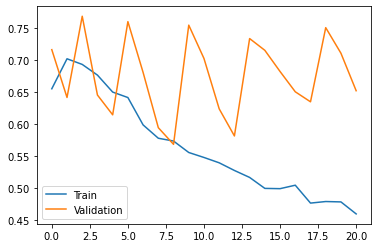

Starting epoch 21


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


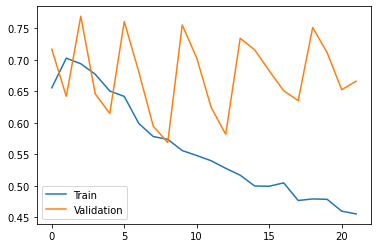

Starting epoch 22


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


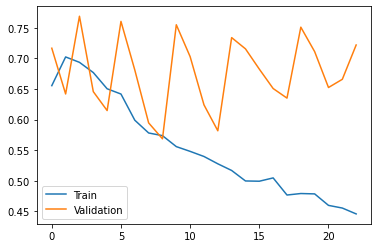

Starting epoch 23


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


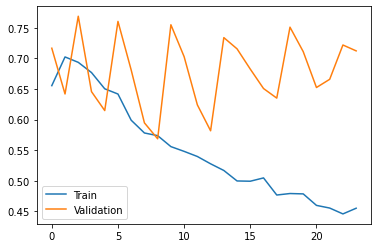

Starting epoch 24


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.
Saving weights...


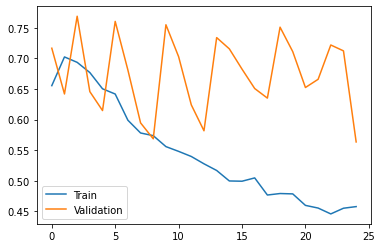

Starting epoch 25


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


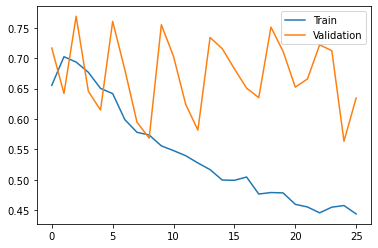

Starting epoch 26


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


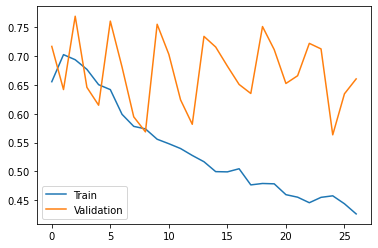

Starting epoch 27


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


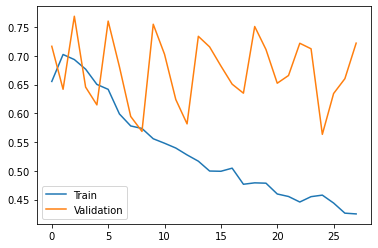

Starting epoch 28


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


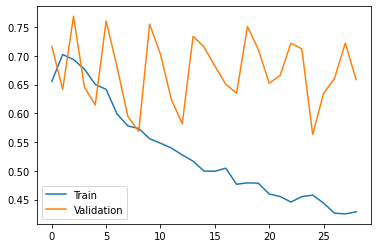

Starting epoch 29


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


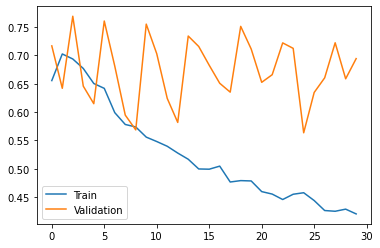

Starting epoch 30


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


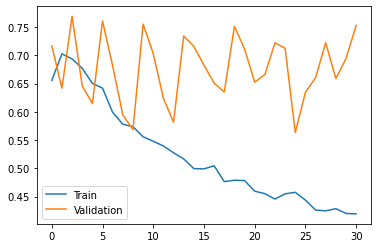

Starting epoch 31


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


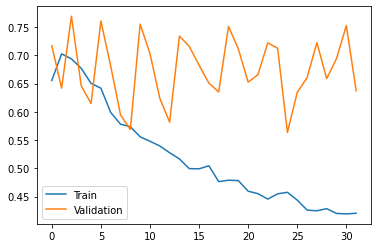

Starting epoch 32


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


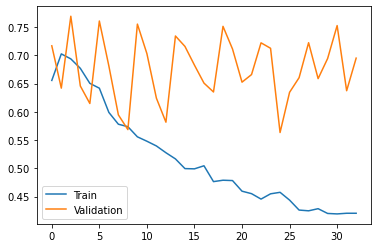

Starting epoch 33


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


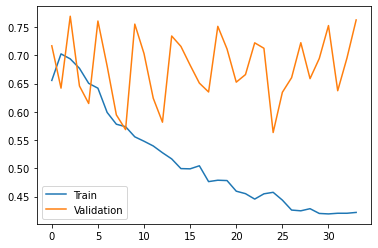

Starting epoch 34


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.
Saving weights...


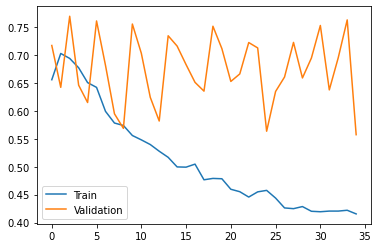

Starting epoch 35


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


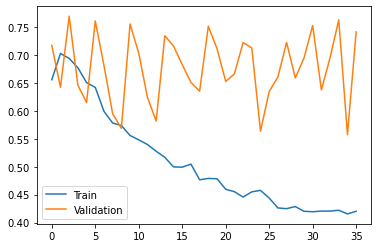

Starting epoch 36


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


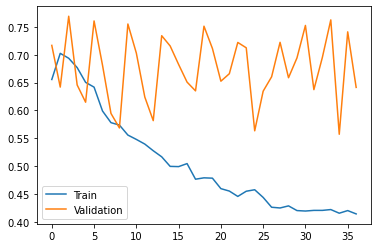

Starting epoch 37


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


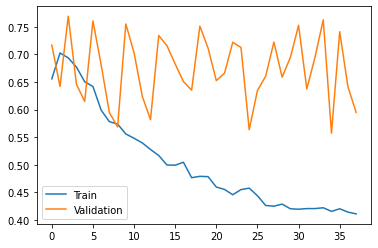

Starting epoch 38


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


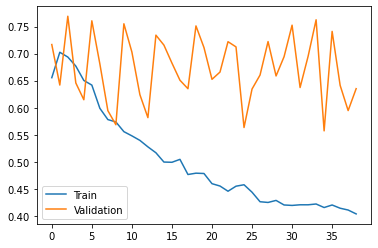

Starting epoch 39


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


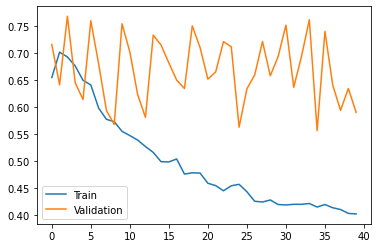

Starting epoch 40


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


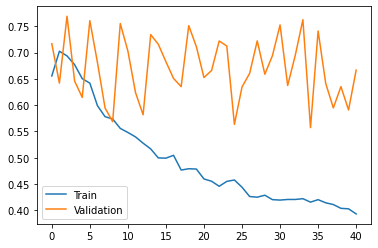

Starting epoch 41


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


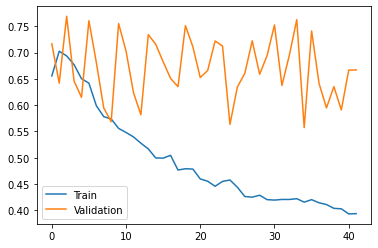

Starting epoch 42


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


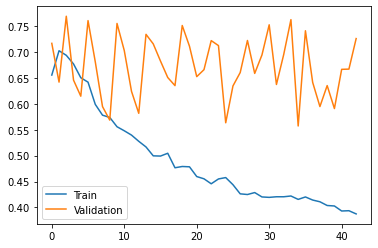

Starting epoch 43


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


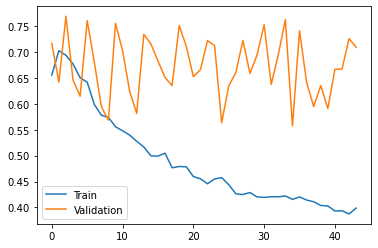

Starting epoch 44


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


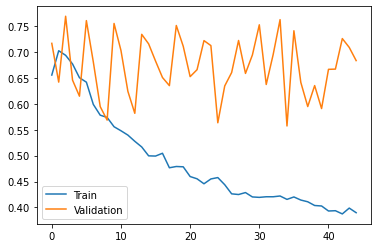

Starting epoch 45


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


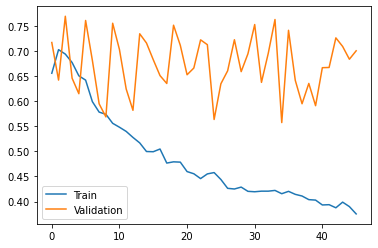

Starting epoch 46


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


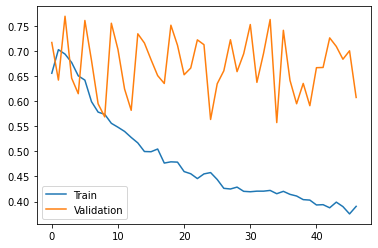

Starting epoch 47


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


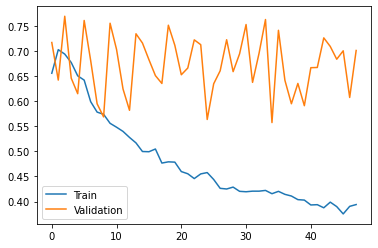

Starting epoch 48


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 1.


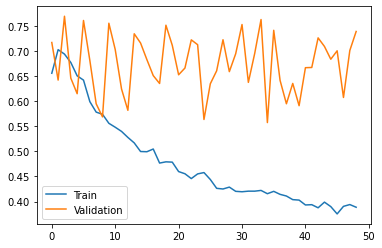

Starting epoch 49


  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [270.3548278808594, 287.19354248046875, 270.3548278808594, 290.0] for target at index 0.


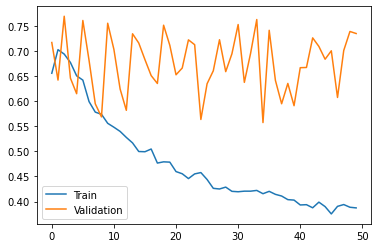

In [177]:
number_epochs = 50  #TODO: Choose
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9)#TODO: Choose, momentum=#TODO: Choose)

train_loss = []
val_loss = []
best_loss = 10000

for epoch in range(number_epochs):
    print(f"Starting epoch {epoch}")

    if epoch > 0:
        plt.figure()

    model.train()
    train_loss.append(0)
    for images, labels in tqdm(train_batch_gen):
        images = list(image.to(device) for image in images)
        labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
    
        try:
            loss_dict = model(images, labels)

            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step() 

        except (ValueError, RuntimeError) as e:
            print(e)
            failed_img, failed_labels = images, labels
            next

        train_loss[epoch] += losses.cpu().data
    train_loss[epoch] /= len(train_dataset)

    if epoch > 0:
        train_plt, = plt.plot(train_loss, label = 'Train')

  
    val_loss.append(0)
    with torch.no_grad():
        for images, labels in tqdm(val_batch_gen):
            images = list(image.to(device) for image in images)
            labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
            try:
                loss_dict = model(images, labels)
      
                losses = sum(loss for loss in loss_dict.values())
                val_loss[epoch] += losses.cpu().data
            except (ValueError, RuntimeError) as e:
                print(e)
                failed_img, failed_labels = images, labels
                next
            
        val_loss[epoch] /= len(val_dataset)
    if val_loss[-1] < best_loss:
        print('Saving weights...')
        best_loss = val_loss[-1]
        torch.save(model.state_dict(), '/home/costia/birds_project/models/faster_RCNN.pt')
    

    if epoch > 0:
        val_plt, = plt.plot(val_loss, label = 'Validation')
        plt.legend(handles=[train_plt, val_plt])
        plt.show()
    torch.cuda.empty_cache()

In [59]:
torch.save(model.state_dict(), '/home/costia/birds_project/models/faster_RCNN.pt')

In [149]:
model.load_state_dict(torch.load('/home/costia/birds_project/models/faster_RCNN.pt'))

<All keys matched successfully>

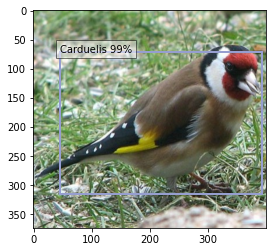

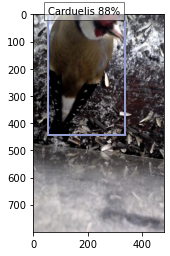

In [181]:
model.eval()
imgs, targets = next(iter(dataloaders['val']))
inputs = list(img.to(device) for img in imgs)
targets = [{k:v.to(device) for k,v in t.items()} for t in targets] 
preds = model(inputs)

for img, info in zip(imgs, preds):
    plot_detection(img, info, conf_lvl=0.8, with_text=True,swap = False)

  0%|          | 0/560 [00:00<?, ?it/s]

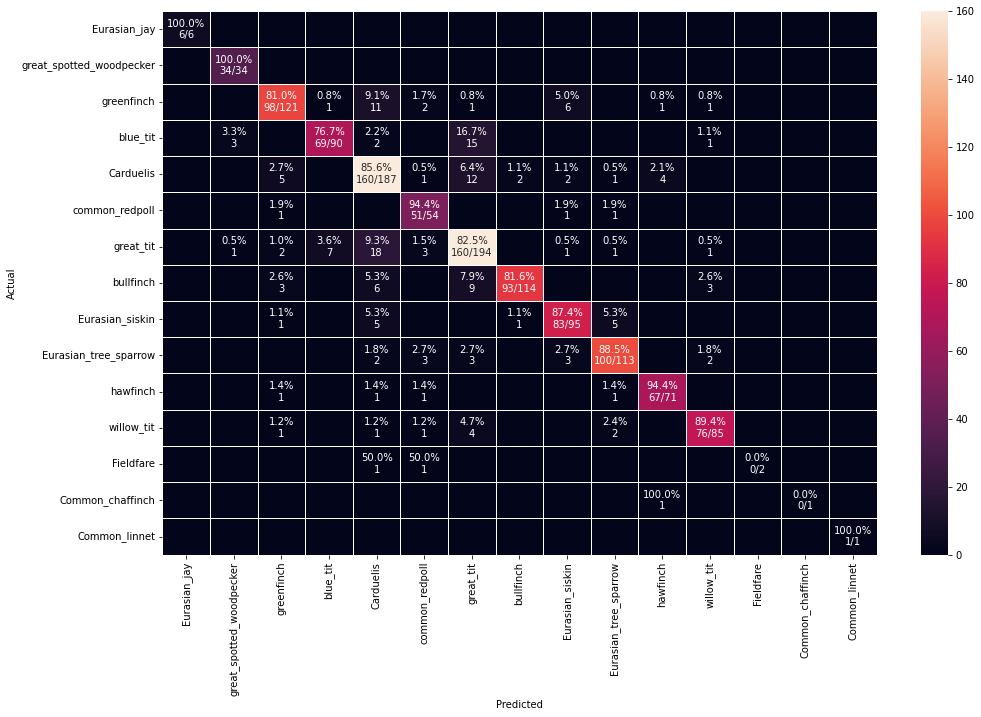

In [86]:
confusion_matrix(val_batch_gen, model)

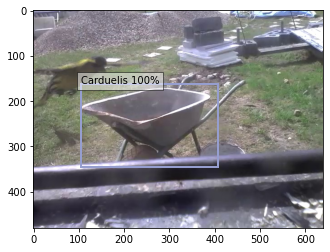

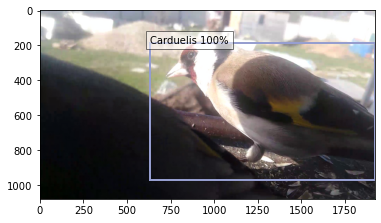

In [187]:
path_test = '/home/costia/birds_new_data/annotations'
test_img_dir = '/home/costia/birds_new_data/img/'
test_path_list = [os.path.join(path_test, path) for path in os.listdir(path_test)]

test_dataset = BirdsDataset(transform=val_transform,
                            annotation_paths = test_path_list,
                            images_dir  = test_img_dir)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,
                                            shuffle = True,
                                            collate_fn=collate_fn)

model.eval()
imgs, targets = next(iter(test_batch_gen))
inputs = list(img.to(device) for img in imgs)
targets = [{k:v.to(device) for k,v in t.items()} for t in targets] 
preds = model(inputs)

for img, info in zip(imgs, preds):
    plot_detection(img, info, conf_lvl=0.8, with_text=True,swap = False)


  0%|          | 0/159 [00:00<?, ?it/s]

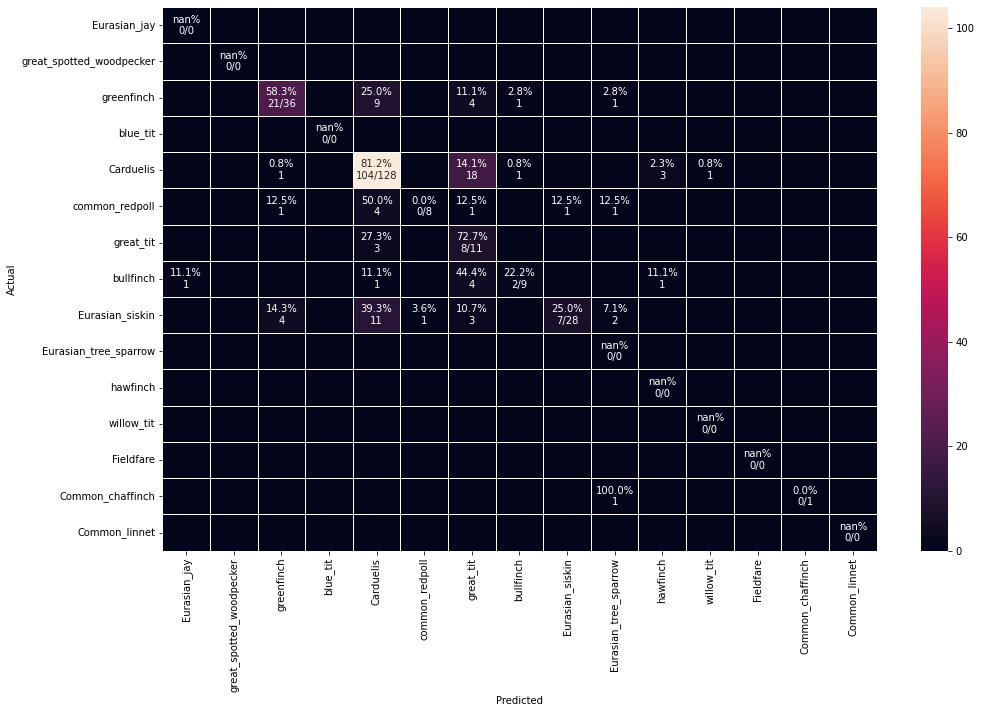

In [175]:
confusion_matrix(test_batch_gen, model)

  0%|          | 0/159 [00:00<?, ?it/s]

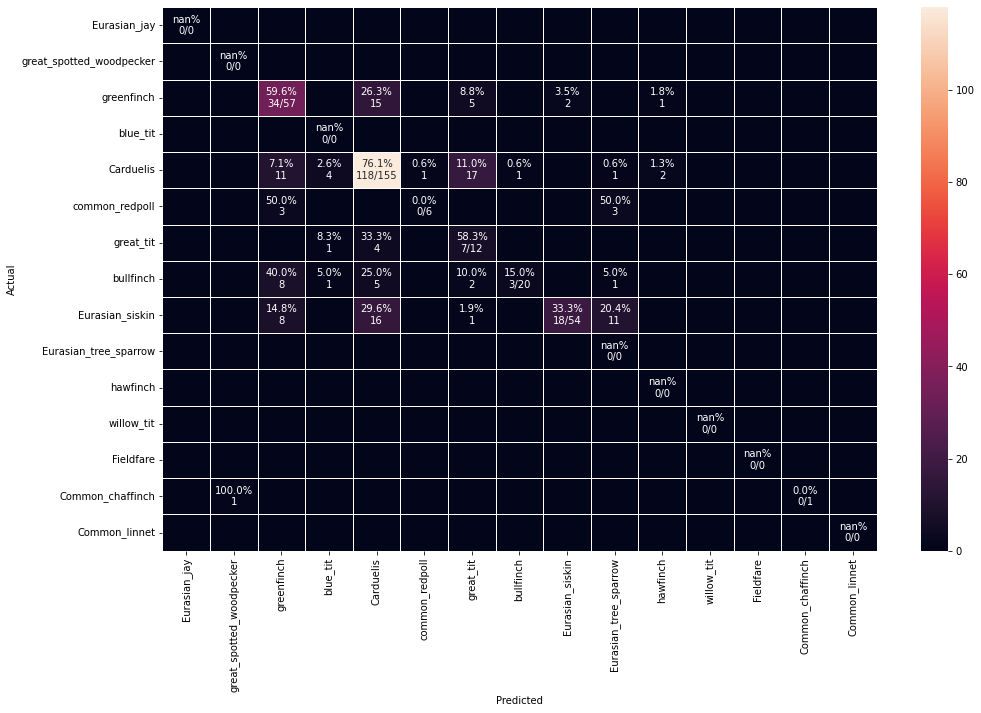

In [182]:
confusion_matrix(test_batch_gen, model)

  0%|          | 0/159 [00:00<?, ?it/s]

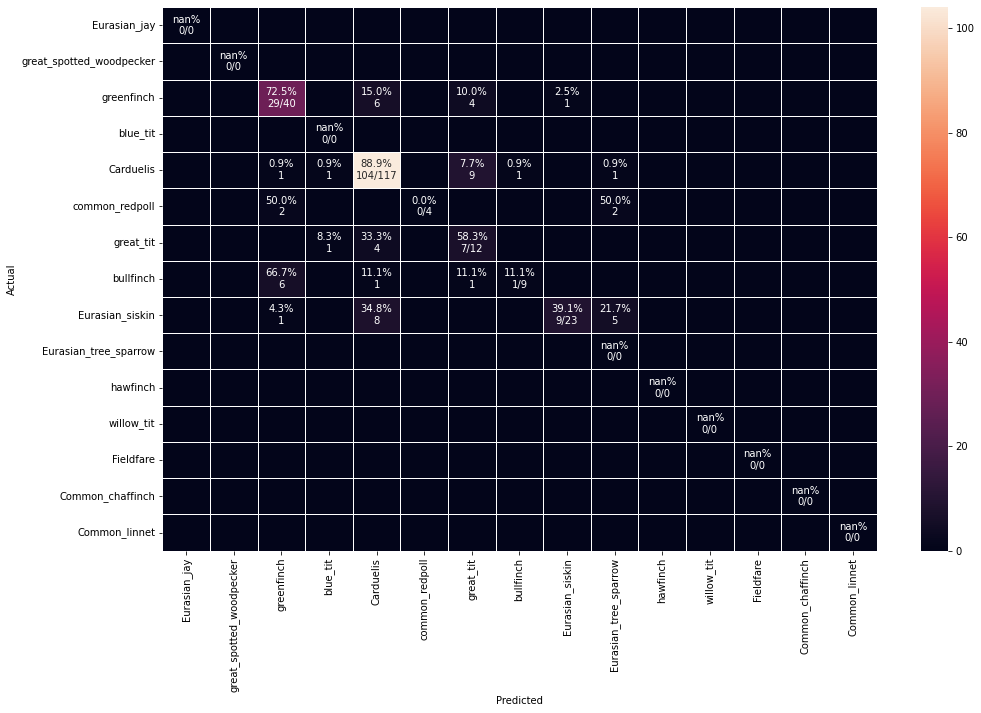

In [189]:
confusion_matrix(test_batch_gen, model, treshold=0.9)